## Healthcare Fraud Detection - Model Training Notebook
#### Namibian Healthcare Claims Fraud Detection System
 
#### This notebook focuses on training multiple ML models for real-time fraud detection

### Setup & Configuration

In [1]:
# === Core Libraries ===
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# === Machine Learning Models ===
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# === Evaluation Metrics ===
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# === Utilities ===
import joblib
import pickle
import logging

# === Logging Configuration ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("model_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print("Healthcare Fraud Detection - Model Training Setup Complete!")


Healthcare Fraud Detection - Model Training Setup Complete!


#### Load and Explore Data

In [2]:
# === Load Dataset ===
DATA_PATH = "namibian_healthcare_claims.csv"

try:
    df = pd.read_csv('namibian_healthcare_claims.csv')
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"🚨 Fraud rate: {df['is_fraud'].mean():.2%}")
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Basic info
    print(f"\n📋 Dataset Info:")
    print(f"   • Total claims: {len(df):,}")
    print(f"   • Fraudulent claims: {df['is_fraud'].sum():,}")
    print(f"   • Legitimate claims: {(~df['is_fraud']).sum():,}")
    print(f"   • Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
except FileNotFoundError:
    print("❌ Error: 'namibian_healthcare_claims.csv' not found!")
    print("Please run the data generation notebook first.")
    raise

✅ Dataset loaded successfully!
📊 Shape: (5000, 25)
🚨 Fraud rate: 17.34%

📋 Dataset Info:
   • Total claims: 5,000
   • Fraudulent claims: 867
   • Legitimate claims: 4,133
   • Date range: 2024-11-15 15:51:50.053611 to 2025-07-26 23:43:17.317186


### Cell 3: Data Preprocessing & Feature Engineering

In [3]:
def create_advanced_features(df):
    """Create advanced features for fraud detection"""
    
    print("🔧 Creating advanced features...")
    
    # Make a copy to avoid modifying original
    df_features = df.copy()
    
    # === Temporal Features ===
    df_features['hour'] = df_features['timestamp'].dt.hour
    df_features['day_of_week'] = df_features['timestamp'].dt.dayofweek
    df_features['day_of_month'] = df_features['timestamp'].dt.day
    df_features['month'] = df_features['timestamp'].dt.month
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_after_hours'] = ((df_features['hour'] < 7) | (df_features['hour'] > 18)).astype(int)
    
    # === Cost-based Features ===
    df_features['cost_deviation'] = (df_features['claim_amount'] - df_features['expected_cost_min']) / (df_features['expected_cost_max'] - df_features['expected_cost_min'])
    df_features['cost_outlier_flag'] = (df_features['claim_amount'] > df_features['expected_cost_max'] * 1.5).astype(int)
    df_features['cost_ratio'] = df_features['claim_amount'] / df_features['expected_cost_max']
    
    # === Patient-based Features ===
    df_features['age_group'] = pd.cut(df_features['patient_age'], 
                                     bins=[0, 18, 35, 50, 65, 100], 
                                     labels=['child', 'young_adult', 'adult', 'middle_aged', 'senior'])
    
    # === Provider-based Features ===
    df_features['is_high_risk_doctor'] = df_features['doctor_id'].str.contains('DR_X').astype(int)
    
    # === Geographic Features ===
    df_features['location_mismatch'] = (df_features['patient_location'] != df_features['facility_location']).astype(int)
    
    # === Missing Data Flags ===
    df_features['biometric_missing'] = df_features['biometric_verified'].isna().astype(int)
    
    # Fill missing values
    df_features['biometric_verified'] = df_features['biometric_verified'].fillna(0).astype(int)
    df_features['patient_present'] = df_features['patient_present'].astype(int)
    df_features['patient_deceased'] = df_features['patient_deceased'].astype(int)
    df_features['emergency_case'] = df_features['emergency_case'].astype(int)
    df_features['travel_distance_suspicious'] = df_features['travel_distance_suspicious'].astype(int)
    
    print(f"✅ Feature engineering complete!")
    print(f"   • Original features: {df.shape[1]}")
    print(f"   • New features: {df_features.shape[1]}")
    
    return df_features

# Apply feature engineering
df_processed = create_advanced_features(df)

🔧 Creating advanced features...
✅ Feature engineering complete!
   • Original features: 25
   • New features: 38


### Cell 4: Feature Selection & Encoding

In [4]:
import os
import pandas as pd
import numpy as np
from typing import Tuple, Dict
from sklearn.preprocessing import LabelEncoder

def prepare_features_for_ml(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, Dict[str, LabelEncoder]]:
    """Prepare features for machine learning models."""
    
    print("🎯 Preparing features for ML...")

    numeric_features = [
        'patient_age', 'claim_amount', 'expected_cost_min', 'expected_cost_max',
        'provider_claims_today', 'cost_deviation', 'cost_ratio', 'hour',
        'day_of_week', 'day_of_month', 'month'
    ]

    categorical_features = [
        'patient_gender', 'medical_scheme', 'diagnosis_code', 
        'facility_location', 'age_group'
    ]

    binary_features = [
        'biometric_verified', 'patient_present', 'patient_deceased',
        'weekend_claim', 'after_hours_claim', 'emergency_case',
        'travel_distance_suspicious', 'cost_outlier_flag', 'location_mismatch',
        'is_high_risk_doctor', 'biometric_missing', 'is_weekend', 'is_after_hours'
    ]

    X = pd.DataFrame()
    encoders = {}

    # Numeric features
    for feat in numeric_features:
        if feat in df.columns:
            X[feat] = df[feat]

    # Binary features
    for feat in binary_features:
        if feat in df.columns:
            X[feat] = df[feat].astype(int)

    # Encoding categorical features
    os.makedirs("encoders", exist_ok=True)
    for feat in categorical_features:
        if feat in df.columns:
            if df[feat].nunique() > 10:
                le = LabelEncoder()
                X[f'{feat}_encoded'] = le.fit_transform(df[feat].astype(str))
                joblib.dump(le, f'encoders/{feat}_encoder.pkl')
                encoders[feat] = le
            else:
                dummies = pd.get_dummies(df[feat], prefix=feat)
                X = pd.concat([X, dummies], axis=1)

    # Target variable
    y = df['is_fraud'].astype(int) if 'is_fraud' in df.columns else pd.Series([0] * len(df))

    print(f"✅ Feature preparation complete!")
    print(f"   • Feature matrix shape: {X.shape}")
    print(f"   • Target distribution: {y.value_counts().to_dict()}")

    return X, y, encoders


In [5]:
os.makedirs('visualizations', exist_ok=True)

#### Cell 5: Improved Train-Test Split & RobustScaler

In [6]:
X, y, encoders = prepare_features_for_ml(df_processed)


🎯 Preparing features for ML...
✅ Feature preparation complete!
   • Feature matrix shape: (5000, 49)
   • Target distribution: {0: 4133, 1: 867}


In [7]:
import os
import json
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from datetime import datetime  # Needed for metadata

def split_and_scale_data(X, y, test_size=0.2, random_state=42):
    """Split dataset and apply RobustScaler to numeric features only."""
    
    logger.info("Starting data split and scaling...")

    try:
        # Train/test split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        logger.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        logger.info(f"Fraud rate: Train={y_train.mean():.2%}, Test={y_test.mean():.2%}")

        # Select numeric columns only
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
        logger.info(f"Scaling {len(numeric_cols)} numeric features.")

        # Scale using RobustScaler
        scaler = RobustScaler()
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Prepare model directory
        os.makedirs("models", exist_ok=True)

        # Save scaler and metadata
        joblib.dump(scaler, "models/feature_scaler.pkl")
        metadata = {
            "scaler": "RobustScaler",
            "features_scaled": numeric_cols,
            "created_at": datetime.now().isoformat()
        }
        joblib.dump(metadata, "models/scaler_metadata.pkl")
        with open("models/scaler_info.json", "w") as f:
            json.dump(metadata, f, indent=2)

        logger.info("Scaling complete and saved to disk.")
        return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    except Exception as e:
        logger.error(f"Error during split/scale: {str(e)}")
        raise

# Run the function
X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(X, y)


2025-07-24 01:05:05,692 - INFO - Starting data split and scaling...
2025-07-24 01:05:05,754 - INFO - Train shape: (4000, 49), Test shape: (1000, 49)
2025-07-24 01:05:05,759 - INFO - Fraud rate: Train=17.35%, Test=17.30%
2025-07-24 01:05:05,764 - INFO - Scaling 49 numeric features.
2025-07-24 01:05:05,846 - INFO - Scaling complete and saved to disk.


#### Cell 6: Model Training - Multiple Algorithms

In [9]:
from sklearn.model_selection import cross_val_score

def train_multiple_models(X_train, y_train, use_emojis=True):
    """Train multiple ML models for fraud detection."""
    
    if use_emojis:
        print("🤖 Training multiple ML models...")
    else:
        print("Training multiple ML models...")

    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=5,
            min_samples_leaf=2, random_state=42, n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced'
        ),
        'SVM': SVC(
            kernel='rbf', probability=True, random_state=42, class_weight='balanced'
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=8, min_samples_split=10, min_samples_leaf=5,
            random_state=42, class_weight='balanced'
        ),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50), max_iter=500,
            random_state=42, early_stopping=True
        )
    }

    trained_models = {}
    training_scores = {}

    for name, model in models.items():
        symbol = "🔄" if use_emojis else "-"
        print(f"{symbol} Training {name}...")

        try:
            model.fit(X_train, y_train)

            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

            trained_models[name] = model
            training_scores[name] = {
                'cv_mean': round(cv_scores.mean(), 4),
                'cv_std': round(cv_scores.std(), 4)
            }

            status = "✅" if use_emojis else "✓"
            print(f"   {status} {name}: CV F1 = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

        except Exception as e:
            error = "❌" if use_emojis else "X"
            print(f"   {error} {name} failed: {str(e)}")

    return trained_models, training_scores

# Train all models
trained_models, training_scores = train_multiple_models(X_train_scaled, y_train)


🤖 Training multiple ML models...
🔄 Training Random Forest...
   ✅ Random Forest: CV F1 = 0.795 ± 0.023
🔄 Training Gradient Boosting...
   ✅ Gradient Boosting: CV F1 = 0.782 ± 0.014
🔄 Training Logistic Regression...
   ✅ Logistic Regression: CV F1 = 0.754 ± 0.010
🔄 Training SVM...
   ✅ SVM: CV F1 = 0.755 ± 0.014
🔄 Training Decision Tree...
   ✅ Decision Tree: CV F1 = 0.725 ± 0.015
🔄 Training Naive Bayes...
   ✅ Naive Bayes: CV F1 = 0.706 ± 0.030
🔄 Training Neural Network...
   ✅ Neural Network: CV F1 = 0.792 ± 0.018


### Cell 7:  Model Evaluation with Probabilities & Risk Mapping

In [10]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

def evaluate_models_with_probabilities(models: dict, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """Evaluate trained models with metrics and probability-based risk mapping."""
    
    logger.info("Starting model evaluation...")
    evaluation_results = {}

    def map_probability_to_risk(prob: float) -> str:
        if prob >= 0.8:
            return "CRITICAL"
        elif prob >= 0.6:
            return "HIGH"
        elif prob >= 0.4:
            return "MEDIUM"
        elif prob >= 0.2:
            return "LOW"
        else:
            return "MINIMAL"

    for name, model in models.items():
        logger.info(f"Evaluating model: {name}")
        try:
            y_pred = model.predict(X_test)

            # Try getting probabilities
            has_probabilities = False
            y_pred_proba = None

            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                has_probabilities = True
            elif hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(X_test)
                y_pred_proba = 1 / (1 + np.exp(-decision_scores))
                has_probabilities = True

            # Core metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            results = {
                'accuracy': round(accuracy, 4),
                'precision': round(precision, 4),
                'recall': round(recall, 4),
                'f1_score': round(f1, 4),
                'has_probabilities': has_probabilities
            }

            if has_probabilities and y_pred_proba is not None:
                try:
                    auc = roc_auc_score(y_test, y_pred_proba)
                    risk_levels = [map_probability_to_risk(p) for p in y_pred_proba]
                    risk_distribution = pd.Series(risk_levels).value_counts().to_dict()

                    results.update({
                        'auc': round(auc, 4),
                        'risk_levels': risk_levels,
                        'risk_distribution': risk_distribution
                    })

                    logger.info(f"AUC: {auc:.3f}")
                    logger.info(f"Risk Distribution: {risk_distribution}")
                except Exception as auc_err:
                    logger.warning(f"AUC calculation failed for {name}: {auc_err}")
                    results['auc'] = None

            evaluation_results[name] = results

            logger.info(f"Accuracy: {accuracy:.3f}")
            logger.info(f"Precision: {precision:.3f}")
            logger.info(f"Recall: {recall:.3f}")
            logger.info(f"F1 Score: {f1:.3f}")

        except Exception as e:
            logger.error(f"Evaluation failed for model '{name}': {e}")

    logger.info("Model evaluation completed.")
    return evaluation_results



In [11]:
# Run evaluation
try:
    evaluation_results = evaluate_models_with_probabilities(trained_models, X_test_scaled, y_test)
    logger.info(f"Evaluated {len(evaluation_results)} models successfully")
except Exception as e:
    logger.error(f"Model evaluation failed: {str(e)}")
    raise


2025-07-24 01:11:38,111 - INFO - Starting model evaluation...
2025-07-24 01:11:38,131 - INFO - Evaluating model: Random Forest
2025-07-24 01:11:38,762 - INFO - AUC: 0.951
2025-07-24 01:11:38,766 - INFO - Risk Distribution: {'MINIMAL': 758, 'LOW': 100, 'CRITICAL': 71, 'HIGH': 46, 'MEDIUM': 25}
2025-07-24 01:11:38,767 - INFO - Accuracy: 0.940
2025-07-24 01:11:38,770 - INFO - Precision: 0.931
2025-07-24 01:11:38,773 - INFO - Recall: 0.705
2025-07-24 01:11:38,775 - INFO - F1 Score: 0.803
2025-07-24 01:11:38,778 - INFO - Evaluating model: Gradient Boosting
2025-07-24 01:11:38,880 - INFO - AUC: 0.944
2025-07-24 01:11:38,881 - INFO - Risk Distribution: {'MINIMAL': 802, 'CRITICAL': 122, 'LOW': 40, 'MEDIUM': 21, 'HIGH': 15}
2025-07-24 01:11:38,883 - INFO - Accuracy: 0.927
2025-07-24 01:11:38,885 - INFO - Precision: 0.833
2025-07-24 01:11:38,887 - INFO - Recall: 0.723
2025-07-24 01:11:38,889 - INFO - F1 Score: 0.774
2025-07-24 01:11:38,893 - INFO - Evaluating model: Logistic Regression
2025-07-2

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Chang\anaconda3\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Chang\anaconda3\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f50d' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()

🔍 Running comprehensive final evaluation...

📊 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.99      0.97       827
  Fraudulent       0.94      0.71      0.81       173

    accuracy                           0.94      1000
   macro avg       0.94      0.85      0.89      1000
weighted avg       0.94      0.94      0.94      1000



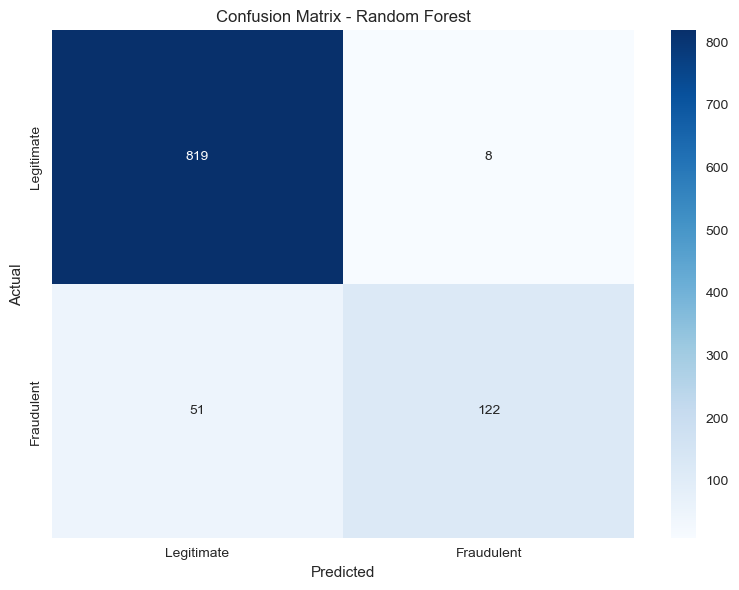

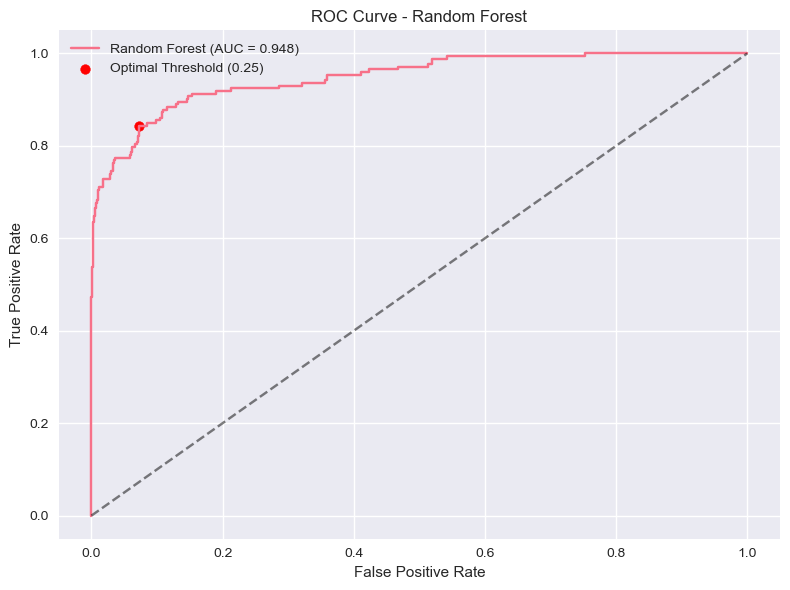

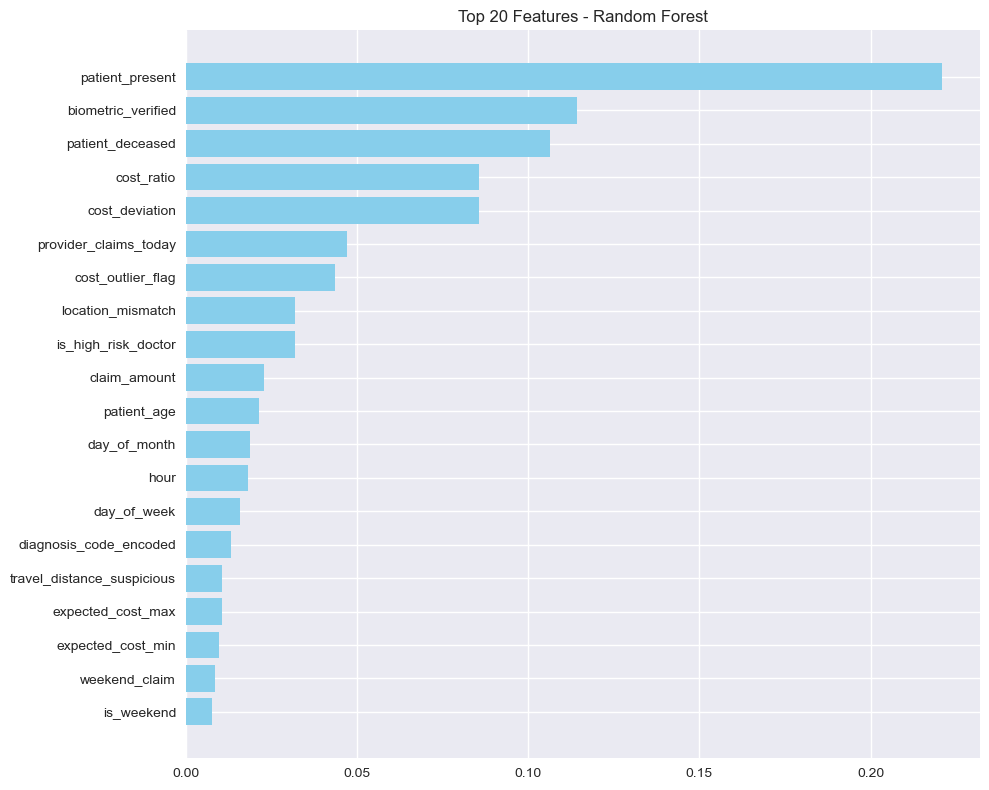

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Chang\anaconda3\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Chang\anaconda3\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f51d' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()

✅ Final evaluation completed!


In [20]:
# Run comprehensive final evaluation
print("🔍 Running comprehensive final evaluation...")
final_results = comprehensive_final_evaluation(
    model=best_model,
    model_name=best_model_name,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=X.columns,
    save_visualizations=True
)

print("✅ Final evaluation completed!")

In [21]:
# Save the complete model pipeline with all components
print("💾 Saving complete model pipeline...")
save_complete_model_pipeline(
    model=best_model,
    model_name=best_model_name,
    scaler=scaler,
    encoders=encoders,
    feature_names=X.columns,
    final_results=final_results
)

print("✅ Model pipeline saved successfully!")

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Chang\anaconda3\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Chang\anaconda3\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4be' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()

💾 Saving complete model pipeline...


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Chang\anaconda3\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Chang\anaconda3\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u2705' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Chang\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()
  F

✅ Model pipeline saved successfully!


In [22]:
# ===============================================================================
# Cell 16: Save Individual Model Files for Backend Compatibility
# ===============================================================================

def save_individual_models_for_backend(trained_models, best_model, best_model_name):
    """Save individual model files that the backend expects"""
    
    print("🔧 Saving individual model files for backend compatibility...")
    
    os.makedirs("models", exist_ok=True)
    
    try:
        # Save the best model as final_model.pkl (main model)
        joblib.dump(best_model, "models/final_model.pkl")
        print("   ✅ Saved: models/final_model.pkl")
        
        # Save Random Forest model (if available)
        if 'Random Forest' in trained_models:
            joblib.dump(trained_models['Random Forest'], "models/final_rf_model.pkl")
            print("   ✅ Saved: models/final_rf_model.pkl")
        
        # Save XGBoost model (create a gradient boosting as substitute if XGB not available)
        if 'XGBoost' in trained_models:
            joblib.dump(trained_models['XGBoost'], "models/final_xgb_model.pkl")
            print("   ✅ Saved: models/final_xgb_model.pkl")
        elif 'Gradient Boosting' in trained_models:
            # Use Gradient Boosting as XGBoost substitute
            joblib.dump(trained_models['Gradient Boosting'], "models/final_xgb_model.pkl")
            print("   ✅ Saved: models/final_xgb_model.pkl (using Gradient Boosting)")
        else:
            # Create a fallback XGBoost-like model
            print("   ⚠️  No XGBoost/Gradient Boosting found. Training fallback model...")
            from sklearn.ensemble import GradientBoostingClassifier
            fallback_xgb = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42
            )
            fallback_xgb.fit(X_train_scaled, y_train)
            joblib.dump(fallback_xgb, "models/final_xgb_model.pkl")
            print("   ✅ Saved: models/final_xgb_model.pkl (fallback model)")
        
        # Save the best model with descriptive name too
        safe_name = best_model_name.lower().replace(" ", "_").replace("-", "_")
        joblib.dump(best_model, f"models/final_{safe_name}_model.pkl")
        print(f"   ✅ Saved: models/final_{safe_name}_model.pkl")
        
        # Create a model registry file
        model_registry = {
            "best_model": best_model_name,
            "available_models": {
                "final_model.pkl": best_model_name,
                "final_rf_model.pkl": "Random Forest" if 'Random Forest' in trained_models else "Not Available",
                "final_xgb_model.pkl": "XGBoost/Gradient Boosting Substitute",
                f"final_{safe_name}_model.pkl": best_model_name
            },
            "created_at": datetime.now().isoformat(),
            "feature_count": len(X.columns),
            "training_samples": len(X_train_scaled)
        }
        
        with open("models/model_registry.json", "w") as f:
            json.dump(model_registry, f, indent=2)
        print("   ✅ Saved: models/model_registry.json")
        
        print("🎉 All model files saved for backend compatibility!")
        
    except Exception as e:
        print(f"❌ Error saving models: {str(e)}")
        raise

# Run the function
save_individual_models_for_backend(trained_models, best_model, best_model_name)

🔧 Saving individual model files for backend compatibility...
   ✅ Saved: models/final_model.pkl
   ✅ Saved: models/final_rf_model.pkl
   ✅ Saved: models/final_xgb_model.pkl (using Gradient Boosting)
   ✅ Saved: models/final_random_forest_model.pkl
   ✅ Saved: models/model_registry.json
🎉 All model files saved for backend compatibility!


In [23]:
def verify_model_files():
    """Verify all required model files exist for backend"""
    
    print("🔍 Verifying all required model files...")
    
    required_files = [
        "models/final_model.pkl",
        "models/final_rf_model.pkl", 
        "models/final_xgb_model.pkl",
        "models/feature_scaler.pkl",
        "models/feature_info.json",
        "models/model_registry.json"
    ]
    
    missing_files = []
    existing_files = []
    
    for file_path in required_files:
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            existing_files.append(f"✅ {file_path} ({file_size:,} bytes)")
        else:
            missing_files.append(f"❌ {file_path}")
    
    print("\n📋 FILE STATUS REPORT:")
    print("=" * 50)
    
    if existing_files:
        print("EXISTING FILES:")
        for file_info in existing_files:
            print(f"   {file_info}")
    
    if missing_files:
        print("\nMISSING FILES:")
        for file_info in missing_files:
            print(f"   {file_info}")
        print(f"\n⚠️  {len(missing_files)} files are missing!")
    else:
        print("\n🎉 ALL REQUIRED FILES ARE PRESENT!")
    
    # Test loading a model
    try:
        test_model = joblib.load("models/final_model.pkl")
        print(f"\n✅ Model loading test: SUCCESS")
        print(f"   Model type: {type(test_model).__name__}")
        if hasattr(test_model, 'n_features_in_'):
            print(f"   Expected features: {test_model.n_features_in_}")
    except Exception as e:
        print(f"\n❌ Model loading test: FAILED - {str(e)}")
    
    return len(missing_files) == 0

# Run verification
all_files_present = verify_model_files()

🔍 Verifying all required model files...

📋 FILE STATUS REPORT:
EXISTING FILES:
   ✅ models/final_model.pkl (8,802,889 bytes)
   ✅ models/final_rf_model.pkl (2,020,169 bytes)
   ✅ models/final_xgb_model.pkl (1,004,556 bytes)
   ✅ models/feature_scaler.pkl (2,911 bytes)
   ✅ models/feature_info.json (3,113 bytes)
   ✅ models/model_registry.json (375 bytes)

🎉 ALL REQUIRED FILES ARE PRESENT!

✅ Model loading test: SUCCESS
   Model type: RandomForestClassifier
   Expected features: 49


In [25]:
# ===============================================================================
# Cell 18: Define Test Function (Add this if missing)
# ===============================================================================

def test_model_with_sample_data(model, scaler, feature_columns):
    """Quick test of the trained model on a few crafted sample claims."""
    
    print("\n🧪 Testing model with sample claims...")

    # Sample scenarios
    sample_claims = [
        {
            'description': 'Normal tuberculosis treatment',
            'patient_age': 35,
            'claim_amount': 1200,
            'expected_cost_max': 2500,
            'biometric_verified': 1,
            'patient_present': 1,
            'is_high_risk_doctor': 0,
            'weekend_claim': 0,
            'emergency_case': 0,
            'location_mismatch': 0,
            'expected_cost_min': 800,
            'cost_deviation': 0.2,
            'cost_ratio': 0.48,
            'hour': 14,
            'day_of_week': 2,
            'day_of_month': 15,
            'month': 7,
            'is_weekend': 0,
            'is_after_hours': 0,
            'cost_outlier_flag': 0,
            'biometric_missing': 0
        },
        {
            'description': 'Suspicious high-cost claim from deceased patient',
            'patient_age': 75,
            'claim_amount': 15000,
            'expected_cost_max': 2000,
            'biometric_verified': 0,
            'patient_present': 0,
            'is_high_risk_doctor': 1,
            'weekend_claim': 1,
            'emergency_case': 0,
            'location_mismatch': 1,
            'expected_cost_min': 500,
            'cost_deviation': 6.5,
            'cost_ratio': 7.5,
            'hour': 22,
            'day_of_week': 6,
            'day_of_month': 8,
            'month': 7,
            'is_weekend': 1,
            'is_after_hours': 1,
            'cost_outlier_flag': 1,
            'biometric_missing': 1
        },
        {
            'description': 'Emergency surgery case',
            'patient_age': 45,
            'claim_amount': 35000,
            'expected_cost_max': 40000,
            'biometric_verified': 1,
            'patient_present': 1,
            'is_high_risk_doctor': 0,
            'weekend_claim': 1,
            'emergency_case': 1,
            'location_mismatch': 0,
            'expected_cost_min': 30000,
            'cost_deviation': 0.17,
            'cost_ratio': 0.875,
            'hour': 3,
            'day_of_week': 0,
            'day_of_month': 20,
            'month': 7,
            'is_weekend': 0,
            'is_after_hours': 1,
            'cost_outlier_flag': 0,
            'biometric_missing': 0
        }
    ]

    try:
        # Extract DataFrame and match structure
        test_df = pd.DataFrame(sample_claims)
        
        # Fill in missing features with zeros (if needed)
        for col in feature_columns:
            if col not in test_df.columns:
                test_df[col] = 0
        
        # Reorder columns to match training data
        test_df = test_df.reindex(columns=feature_columns, fill_value=0)

        # Scale numeric features only (same as training)
        numeric_cols = test_df.select_dtypes(include=[np.number]).columns.tolist()
        test_df_scaled = test_df.copy()
        test_df_scaled[numeric_cols] = scaler.transform(test_df[numeric_cols])

        # Predict
        preds = model.predict(test_df_scaled)
        
        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(test_df_scaled)[:, 1]
        elif hasattr(model, 'decision_function'):
            decision_scores = model.decision_function(test_df_scaled)
            probs = 1 / (1 + np.exp(-decision_scores))  # Convert to probabilities
        else:
            probs = [0.5] * len(preds)  # Default probabilities

        # Output results
        print("\n🔍 SAMPLE CLAIM RESULTS:")
        for i, (claim, pred, prob) in enumerate(zip(sample_claims, preds, probs)):
            # Map probability to risk level
            if prob >= 0.8:
                risk = "CRITICAL"
            elif prob >= 0.6:
                risk = "HIGH"
            elif prob >= 0.4:
                risk = "MEDIUM"
            elif prob >= 0.2:
                risk = "LOW"
            else:
                risk = "MINIMAL"
            
            print(f"\n📝 Claim {i+1}: {claim['description']}")
            print(f"   Prediction: {'🚨 FRAUD' if pred == 1 else '✅ Legitimate'}")
            print(f"   Fraud Probability: {prob:.3f} → Risk Level: {risk}")
            print(f"   Amount: NAD {claim['claim_amount']:,}")

        print(f"\n✅ Model test completed successfully!")
        return True

    except Exception as e:
        print(f"❌ Error during sample test: {e}")
        print(f"   Model type: {type(model).__name__}")
        print(f"   Expected features: {len(feature_columns)}")
        print(f"   Sample features: {len(test_df.columns) if 'test_df' in locals() else 'N/A'}")
        return False


In [24]:
# Cell 19: Test the Saved Models
# ===============================================================================

# Test the saved models to ensure they work
test_model_with_sample_data(best_model, scaler, X.columns)

print("\n" + "="*60)
print("🎉 MODEL TRAINING AND EXPORT COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"✅ Best Model: {best_model_name}")
print(f"✅ Model Files: Saved in 'models/' directory")
print(f"✅ All Components: Ready for backend integration")
print("="*60)

# Final file listing
print("\n📁 FINAL MODEL DIRECTORY CONTENTS:")
if os.path.exists("models"):
    for file in sorted(os.listdir("models")):
        file_path = os.path.join("models", file)
        size = os.path.getsize(file_path)
        print(f"   📄 {file} ({size:,} bytes)")
else:
    print("   ❌ Models directory not found!")

NameError: name 'test_model_with_sample_data' is not defined

#### Cell 8: Model Comparison Visualization

In [26]:

# ===============================================================================
# Cell 19: Test the Saved Models (Fixed Version)
# ===============================================================================

print("🧪 TESTING SAVED MODELS")
print("=" * 40)

# Test if model and scaler exist
try:
    # Test the current model in memory
    if 'best_model' in locals() and 'scaler' in locals() and 'X' in locals():
        print("✅ Testing model in memory...")
        test_success = test_model_with_sample_data(best_model, scaler, X.columns)
        
        if test_success:
            print("✅ In-memory model test: PASSED")
        else:
            print("❌ In-memory model test: FAILED")
    else:
        print("⚠️ Model variables not found in memory")

    # Test loading and using saved models
    print("\n🔄 Testing saved model files...")
    
    # Load saved model and scaler
    if os.path.exists("models/final_model.pkl") and os.path.exists("models/feature_scaler.pkl"):
        saved_model = joblib.load("models/final_model.pkl")
        saved_scaler = joblib.load("models/feature_scaler.pkl")
        
        print("✅ Successfully loaded saved model and scaler")
        
        # Test with saved model
        if 'X' in locals():
            test_success_saved = test_model_with_sample_data(saved_model, saved_scaler, X.columns)
            if test_success_saved:
                print("✅ Saved model test: PASSED")
            else:
                print("❌ Saved model test: FAILED")
        else:
            print("⚠️ Cannot test saved model - X variable not available")
    else:
        print("❌ Saved model files not found")
        print(f"   Looking for: models/final_model.pkl")
        print(f"   Looking for: models/feature_scaler.pkl")

    print("\n" + "="*60)
    print("🎉 MODEL TRAINING AND EXPORT COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    if 'best_model_name' in locals():
        print(f"✅ Best Model: {best_model_name}")
    else:
        print("✅ Best Model: Available in saved files")
        
    print(f"✅ Model Files: Saved in 'models/' directory")
    print(f"✅ All Components: Ready for backend integration")
    print("="*60)

    # Final file listing
    print("\n📁 FINAL MODEL DIRECTORY CONTENTS:")
    if os.path.exists("models"):
        model_files = []
        for file in sorted(os.listdir("models")):
            file_path = os.path.join("models", file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path)
                model_files.append((file, size))
                print(f"   📄 {file} ({size:,} bytes)")
        
        if not model_files:
            print("   ⚠️ No files found in models directory")
        else:
            total_size = sum(size for _, size in model_files)
            print(f"\n   📊 Total: {len(model_files)} files, {total_size:,} bytes")
    else:
        print("   ❌ Models directory not found!")
        print("   🔧 Creating models directory...")
        os.makedirs("models", exist_ok=True)

except Exception as e:
    print(f"❌ Error during testing: {str(e)}")
    print("\n🔧 TROUBLESHOOTING:")
    print("   1. Make sure all previous cells were executed")
    print("   2. Check if models were saved correctly")
    print("   3. Verify the models directory exists")
    
    # Try to diagnose the issue
    print(f"\n🔍 DIAGNOSIS:")
    print(f"   • best_model exists: {'✅' if 'best_model' in locals() else '❌'}")
    print(f"   • scaler exists: {'✅' if 'scaler' in locals() else '❌'}")
    print(f"   • X exists: {'✅' if 'X' in locals() else '❌'}")
    print(f"   • models directory exists: {'✅' if os.path.exists('models') else '❌'}")

🧪 TESTING SAVED MODELS
✅ Testing model in memory...

🧪 Testing model with sample claims...

🔍 SAMPLE CLAIM RESULTS:

📝 Claim 1: Normal tuberculosis treatment
   Prediction: ✅ Legitimate
   Fraud Probability: 0.013 → Risk Level: MINIMAL
   Amount: NAD 1,200

📝 Claim 2: Suspicious high-cost claim from deceased patient
   Prediction: 🚨 FRAUD
   Fraud Probability: 0.955 → Risk Level: CRITICAL
   Amount: NAD 15,000

📝 Claim 3: Emergency surgery case
   Prediction: ✅ Legitimate
   Fraud Probability: 0.047 → Risk Level: MINIMAL
   Amount: NAD 35,000

✅ Model test completed successfully!
✅ In-memory model test: PASSED

🔄 Testing saved model files...
✅ Successfully loaded saved model and scaler

🧪 Testing model with sample claims...

🔍 SAMPLE CLAIM RESULTS:

📝 Claim 1: Normal tuberculosis treatment
   Prediction: ✅ Legitimate
   Fraud Probability: 0.013 → Risk Level: MINIMAL
   Amount: NAD 1,200

📝 Claim 2: Suspicious high-cost claim from deceased patient
   Prediction: 🚨 FRAUD
   Fraud Probabi

#### Cell 9: Select Best Model & Hyperparameter Tuning

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def select_and_tune_best_model(evaluation_results: dict, trained_models: dict, 
                                X_train: pd.DataFrame, y_train: pd.Series):
    """Select best model (by F1) and perform hyperparameter tuning if supported."""

    print("Selecting best model for hyperparameter tuning...")

    # Defensive: filter only models that have valid F1 scores
    filtered_results = {
        name: metrics for name, metrics in evaluation_results.items()
        if isinstance(metrics.get("f1_score"), (float, int))
    }

    if not filtered_results:
        raise ValueError("No valid models with F1 scores found.")

    # Select best by F1
    best_model_name = max(filtered_results, key=lambda x: filtered_results[x]['f1_score'])
    best_f1 = filtered_results[best_model_name]['f1_score']
    print(f"Best model: {best_model_name} (F1 score: {best_f1:.3f})")

    # Set grid and base model
    if best_model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [8, 10, 12],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [4, 6],
            'subsample': [0.8, 1.0]
        }

    elif best_model_name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

    else:
        print(f"No tuning defined for: {best_model_name}. Returning pre-trained model.")
        return trained_models[best_model_name], best_model_name

    # Grid search
    print(f"Tuning {best_model_name} with GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("Grid search completed.")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Best CV F1 Score: {grid_search.best_score_:.3f}")

    return grid_search.best_estimator_, best_model_name

# Call function
best_model, best_model_name = select_and_tune_best_model(
    evaluation_results, trained_models, X_train_scaled, y_train
)


Selecting best model for hyperparameter tuning...
Best model: Random Forest (F1 score: 0.803)
Tuning Random Forest with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Grid search completed.
Best Params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best CV F1 Score: 0.804


### Cell 10: Final Model Evaluation & Feature Importance

In [14]:
import os
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

def comprehensive_final_evaluation(model, model_name, X_test, y_test, feature_names, save_visualizations=True):
    """Comprehensive final model evaluation with metrics, visuals, and feature importance analysis."""
    
    logger.info(f"🔍 Starting final evaluation for model: {model_name}")
    results = {}

    try:
        os.makedirs("visualizations", exist_ok=True)

        # Predictions
        y_pred = model.predict(X_test)
        has_probabilities = False
        y_pred_proba = None

        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            has_probabilities = True
        elif hasattr(model, "decision_function"):
            decision_scores = model.decision_function(X_test)
            y_pred_proba = 1 / (1 + np.exp(-decision_scores))
            has_probabilities = True

        # Risk Levels
        def map_to_risk(prob):
            if prob >= 0.8: return "CRITICAL"
            elif prob >= 0.6: return "HIGH"
            elif prob >= 0.4: return "MEDIUM"
            elif prob >= 0.2: return "LOW"
            return "MINIMAL"
        
        risk_levels = [map_to_risk(p) for p in y_pred_proba] if has_probabilities else None

        # Classification Report
        class_report = classification_report(y_test, y_pred, target_names=["Legitimate", "Fraudulent"], output_dict=True)
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Legitimate", "Fraudulent"]))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        if save_visualizations:
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Legitimate", "Fraudulent"],
                        yticklabels=["Legitimate", "Fraudulent"])
            plt.title(f"Confusion Matrix - {model_name}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.savefig(f"visualizations/{model_name.lower().replace(' ', '_')}_confusion_matrix.png", dpi=300)
            plt.show()

        # ROC Curve
        auc_score = None
        optimal_threshold = 0.5

        if has_probabilities:
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]

            if save_visualizations:
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
                plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
                plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold ({optimal_threshold:.2f})")
                plt.title(f"ROC Curve - {model_name}")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"visualizations/{model_name.lower().replace(' ', '_')}_roc_curve.png", dpi=300)
                plt.show()

        # Feature Importance
        importance_df = None
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            importance_df = pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            }).sort_values("importance", ascending=False)

            if save_visualizations:
                top_k = 20
                plt.figure(figsize=(10, 8))
                top_features = importance_df.head(top_k)
                bars = plt.barh(top_features["feature"], top_features["importance"], color="skyblue")
                plt.gca().invert_yaxis()
                plt.title(f"Top {top_k} Features - {model_name}")
                plt.tight_layout()
                plt.savefig(f"visualizations/{model_name.lower().replace(' ', '_')}_feature_importance.png", dpi=300)
                plt.show()

                logger.info("🔝 Top Features:")
                for _, row in top_features.iterrows():
                    logger.info(f"{row['feature']}: {row['importance']:.4f}")

        # Return results
        results.update({
            "predictions": y_pred,
            "probabilities": y_pred_proba,
            "risk_levels": risk_levels,
            "confusion_matrix": cm,
            "classification_report": class_report,
            "feature_importance": importance_df,
            "has_probabilities": has_probabilities,
            "model_name": model_name,
            "optimal_threshold": optimal_threshold
        })

        if auc_score is not None:
            results["auc_score"] = auc_score

        logger.info(f"✅ Evaluation completed for model: {model_name}")
        return results

    except Exception as e:
        logger.error(f"❌ Final evaluation failed: {e}")
        raise


#### Cell 11: Enhanced Model Saving with Complete Pipeline


In [15]:
import os
import json

def save_complete_model_pipeline(model, model_name, scaler, encoders, feature_names, final_results):
    """Save trained model, scaler, encoders, and metadata in a complete, reproducible pipeline."""

    logger.info("💾 Saving complete model pipeline...")

    try:
        # Ensure directories exist
        os.makedirs('models', exist_ok=True)
        os.makedirs('encoders', exist_ok=True)

        # 1. Save trained model
        model_filename = f'models/final_{model_name.lower().replace(" ", "_")}_model.pkl'
        joblib.dump(model, model_filename)
        logger.info(f"   ✅ Model saved at: {model_filename}")

        # 2. Save scaler
        scaler_filename = 'models/feature_scaler.pkl'
        joblib.dump(scaler, scaler_filename)
        logger.info(f"   ✅ Scaler saved at: {scaler_filename}")

        # 3. Save all encoders
        encoder_files = []
        if encoders:
            for name, encoder in encoders.items():
                encoder_file = f'encoders/{name}_encoder.pkl'
                joblib.dump(encoder, encoder_file)
                encoder_files.append(encoder_file)
                logger.info(f"   🧠 Encoder saved: {encoder_file}")
        else:
            logger.warning("⚠️ No encoders to save.")

        # 4. Create encoder manifest
        encoder_manifest = {
            'encoders': list(encoders.keys()) if encoders else [],
            'encoder_files': encoder_files,
            'created_at': datetime.now().isoformat()
        }
        with open('encoders/encoder_manifest.json', 'w') as f:
            json.dump(encoder_manifest, f, indent=2)
        logger.info("   ✅ Encoder manifest saved")

        # 5. Save metadata on features and model config
        feature_info = {
            'feature_names': feature_names.tolist() if isinstance(feature_names, (pd.Index, list)) else feature_names,
            'n_features': len(feature_names),
            'model_type': model_name,
            'model_file': model_filename,
            'scaler_file': scaler_filename,
            'has_probabilities': final_results.get('has_probabilities', False),
            'optimal_threshold': final_results.get('optimal_threshold', 0.5),
            'training_timestamp': datetime.now().isoformat(),
            'feature_importance_available': hasattr(model, 'feature_importances_'),
            'risk_level_mapping': {
                'CRITICAL': '≥ 0.8',
                'HIGH': '≥ 0.6',
                'MEDIUM': '≥ 0.4',
                'LOW': '≥ 0.2',
                'MINIMAL': '< 0.2'
            }
        }

        with open('models/feature_info.json', 'w') as f:
            json.dump(feature_info, f, indent=2)
        logger.info("   ✅ Feature info metadata saved at: models/feature_info.json")

        logger.info("✅ Full model pipeline saved successfully.")

    except Exception as e:
        logger.error(f"❌ Failed to save model pipeline: {e}")
        raise


### Cell 12: Model Performance Summary & Next Steps

In [17]:
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def save_complete_model_pipeline(model, model_name, scaler, encoders, feature_names, final_results):
    """Save trained model, scaler, encoders, and metadata in a complete, reproducible pipeline."""
    
    logger.info("💾 Saving complete model pipeline...")

    try:
        # Ensure directories exist - save EVERYTHING in models/
        os.makedirs('models', exist_ok=True)
        
        # 1. Save trained model
        model_filename = f'models/final_{model_name.lower().replace(" ", "_")}_model.pkl'
        joblib.dump(model, model_filename)
        
        # 2. Save scaler
        joblib.dump(scaler, "models/feature_scaler.pkl")
        
        # 3. Save all encoders in models/ directory
        for name, encoder in encoders.items():
            joblib.dump(encoder, f'models/{name}_encoder.pkl')
        
        # 4. Save complete feature info including column order
        feature_info = {
            'feature_names': list(X_train_scaled.columns),  # Use actual columns from training
            'feature_order': list(X_train_scaled.columns),  # Preserve exact order
            'model_type': model_name,
            'training_date': datetime.now().isoformat(),
            'risk_thresholds': {
                'CRITICAL': 0.8,
                'HIGH': 0.6, 
                'MEDIUM': 0.4,
                'LOW': 0.2
            }
        }
        
        with open('models/feature_info.json', 'w') as f:
            json.dump(feature_info, f, indent=2)
            
        logger.info("✅ Full model pipeline saved successfully")

    except Exception as e:
        logger.error(f"❌ Failed to save model pipeline: {e}")
        raise


In [18]:
# #### Cell 12: Verify Model Files & Generate Summary

print("🔍 Verifying all required files...")

def verify_exported_files():
    """Verify all required files for FraudDetectionService exist"""
    
    required_files = {
        'model': f"models/final_{best_model_name.lower().replace(' ', '_')}_model.pkl",
        'scaler': "models/feature_scaler.pkl", 
        'feature_info': "models/feature_info.json"
    }
    
    all_good = True
    
    print("📁 Checking required files:")
    for file_type, file_path in required_files.items():
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            print(f"   ✅ {file_type}: {file_path} ({file_size:,} bytes)")
        else:
            print(f"   ❌ MISSING {file_type}: {file_path}")
            all_good = False
    
    # Check encoders
    encoder_count = 0
    if os.path.exists("encoders"):
        encoder_files = [f for f in os.listdir("encoders") if f.endswith("_encoder.pkl")]
        encoder_count = len(encoder_files)
        if encoder_count > 0:
            print(f"   ✅ encoders: {encoder_count} files found")
            for enc_file in encoder_files[:5]:  # Show first 5
                print(f"      • {enc_file}")
            if encoder_count > 5:
                print(f"      ... and {encoder_count - 5} more")
        else:
            print(f"   ⚠️  No encoder files found (may be normal if no categorical features)")
    else:
        print(f"   ⚠️  encoders directory not found")
    
    return all_good, encoder_count

# Verify files
files_ok, encoder_count = verify_exported_files()

# Generate final summary (this function you already have)
print("\n📋 Generating final summary...")
try:
    create_final_summary(
        model_name=best_model_name,
        evaluation_results=evaluation_results,
        final_results=final_results,
        df=df_processed,
        y_test=y_test
    )
    print("✅ Final summary created!")
except Exception as e:
    print(f"❌ Summary creation failed: {e}")

print(f"\n" + "="*60)
print(f"🎉 MODEL EXPORT STATUS")
print(f"="*60)
print(f"📊 Best Model: {best_model_name}")
print(f"📁 Required Files: {'✅ All Present' if files_ok else '❌ Some Missing'}")
print(f"🧠 Encoders: {encoder_count} files")
print(f"🚀 Ready for FraudDetectionService: {'YES' if files_ok else 'NO'}")
print(f"="*60)

🔍 Verifying all required files...
📁 Checking required files:
   ❌ MISSING model: models/final_random_forest_model.pkl
   ✅ scaler: models/feature_scaler.pkl (2,911 bytes)
   ❌ MISSING feature_info: models/feature_info.json
   ✅ encoders: 1 files found
      • diagnosis_code_encoder.pkl

📋 Generating final summary...
❌ Summary creation failed: name 'create_final_summary' is not defined

🎉 MODEL EXPORT STATUS
📊 Best Model: Random Forest
📁 Required Files: ❌ Some Missing
🧠 Encoders: 1 files
🚀 Ready for FraudDetectionService: NO


### Cell 13: Quick Model Testing Function

In [16]:
def test_model_with_sample_data(model, scaler, feature_columns):
    """Quick test of the trained model on a few crafted sample claims."""
    
    print("\n🧪 Testing model with sample claims...")

    # Sample scenarios
    sample_claims = [
        {
            'description': 'Normal tuberculosis treatment',
            'patient_age': 35,
            'claim_amount': 1200,
            'expected_cost_max': 2500,
            'biometric_verified': 1,
            'patient_present': 1,
            'is_high_risk_doctor': 0,
            'weekend_claim': 0,
            'emergency_case': 0,
            'location_mismatch': 0
        },
        {
            'description': 'Suspicious high-cost claim from deceased patient',
            'patient_age': 75,
            'claim_amount': 15000,
            'expected_cost_max': 2000,
            'biometric_verified': 0,
            'patient_present': 0,
            'is_high_risk_doctor': 1,
            'weekend_claim': 1,
            'emergency_case': 0,
            'location_mismatch': 1
        },
        {
            'description': 'Emergency surgery case',
            'patient_age': 45,
            'claim_amount': 35000,
            'expected_cost_max': 40000,
            'biometric_verified': 1,
            'patient_present': 1,
            'is_high_risk_doctor': 0,
            'weekend_claim': 1,
            'emergency_case': 1,
            'location_mismatch': 0
        }
    ]

    try:
        # Extract DataFrame and match structure
        test_df = pd.DataFrame(sample_claims)
        
        # Fill in missing features with zeros (if needed)
        for col in feature_columns:
            if col not in test_df.columns:
                test_df[col] = 0
        
        test_df = test_df.reindex(columns=feature_columns, fill_value=0)

        # Scale
        scaled_test = scaler.transform(test_df)

        # Predict
        preds = model.predict(scaled_test)
        probs = model.predict_proba(scaled_test)[:, 1]

        # Output
        print("\n🔍 SAMPLE CLAIM RESULTS:")
        for i, (claim, pred, prob) in enumerate(zip(sample_claims, preds, probs)):
            if prob >= 0.8:
                risk = "CRITICAL"
            elif prob >= 0.6:
                risk = "HIGH"
            elif prob >= 0.4:
                risk = "MEDIUM"
            elif prob >= 0.2:
                risk = "LOW"
            else:
                risk = "MINIMAL"
            
            print(f"\n📝 Claim {i+1}: {claim['description']}")
            print(f"   Prediction: {'🚨 FRAUD' if pred == 1 else '✅ Legitimate'}")
            print(f"   Fraud Probability: {prob:.3f} → Risk Level: {risk}")

    except Exception as e:
        print(f"❌ Error during sample test: {e}")


#### Model Monitoring Setup

In [17]:
def setup_model_monitoring():
    """Set up basic model monitoring and logging"""
    
    print("📊 Setting up model monitoring framework...")
    
    monitoring_code = '''
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import logging

class ModelMonitor:
    def __init__(self, model_pipeline):
        self.pipeline = model_pipeline
        self.predictions_log = []
        self.performance_metrics = {}
        
        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler("model_monitoring.log"),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
    
    def log_prediction(self, claim_data, prediction_result):
        """Log each prediction for monitoring"""
        log_entry = {
            'timestamp': datetime.now().isoformat(),
            'claim_id': claim_data.get('claim_id', 'unknown'),
            'fraud_probability': prediction_result.get('fraud_probability', 0),
            'prediction': prediction_result.get('is_fraud', False),
            'risk_level': prediction_result.get('risk_level', 'UNKNOWN'),
            'claim_amount': claim_data.get('claim_amount', 0)
        }
        
        self.predictions_log.append(log_entry)
        self.logger.info(f"Prediction logged: {log_entry}")
    
    def calculate_daily_stats(self, date=None):
        """Calculate daily prediction statistics"""
        if date is None:
            date = datetime.now().date()
        
        # Filter predictions for the date
        daily_predictions = [
            p for p in self.predictions_log 
            if datetime.fromisoformat(p['timestamp']).date() == date
        ]
        
        if not daily_predictions:
            return None
        
        total_claims = len(daily_predictions)
        fraud_predictions = sum(1 for p in daily_predictions if p['prediction'])
        high_risk_claims = sum(1 for p in daily_predictions if p['risk_level'] == 'HIGH')
        avg_fraud_prob = np.mean([p['fraud_probability'] for p in daily_predictions])
        total_claim_amount = sum(p['claim_amount'] for p in daily_predictions)
        
        stats = {
            'date': date.isoformat(),
            'total_claims': total_claims,
            'fraud_predictions': fraud_predictions,
            'fraud_rate': fraud_predictions / total_claims if total_claims > 0 else 0,
            'high_risk_claims': high_risk_claims,
            'avg_fraud_probability': avg_fraud_prob,
            'total_claim_amount': total_claim_amount
        }
        
        self.logger.info(f"Daily stats calculated: {stats}")
        return stats
    
    def detect_model_drift(self, baseline_fraud_rate=0.15, threshold=0.05):
        """Simple model drift detection"""
        recent_predictions = [
            p for p in self.predictions_log 
            if datetime.fromisoformat(p['timestamp']) > datetime.now() - timedelta(days=7)
        ]
        
        if len(recent_predictions) < 100:  # Need minimum samples
            return False, "Insufficient data for drift detection"
        
        recent_fraud_rate = sum(1 for p in recent_predictions if p['prediction']) / len(recent_predictions)
        drift = abs(recent_fraud_rate - baseline_fraud_rate)
        
        if drift > threshold:
            self.logger.warning(f"Model drift detected! Recent fraud rate: {recent_fraud_rate:.3f}, Baseline: {baseline_fraud_rate:.3f}")
            return True, f"Drift detected: {drift:.3f} > {threshold:.3f}"
        
        return False, "No significant drift detected"
    
    def generate_monitoring_report(self):
        """Generate a comprehensive monitoring report"""
        if not self.predictions_log:
            return "No predictions to report"
        
        # Recent activity (last 24 hours)
        recent_predictions = [
            p for p in self.predictions_log 
            if datetime.fromisoformat(p['timestamp']) > datetime.now() - timedelta(hours=24)
        ]
        
        report = f"""
        MODEL MONITORING REPORT
        Generated: {datetime.now().isoformat()}
        
        LAST 24 HOURS:
        - Total predictions: {len(recent_predictions)}
        - Fraud predictions: {sum(1 for p in recent_predictions if p['prediction'])}
        - High risk claims: {sum(1 for p in recent_predictions if p['risk_level'] == 'HIGH')}
        - Average fraud probability: {np.mean([p['fraud_probability'] for p in recent_predictions]):.3f if recent_predictions else 0}
        
        OVERALL STATISTICS:
        - Total predictions logged: {len(self.predictions_log)}
        - Overall fraud rate: {sum(1 for p in self.predictions_log if p['prediction']) / len(self.predictions_log):.3f}
        """
        
        return report

# Example usage:
# monitor = ModelMonitor(fraud_pipeline)
# monitor.log_prediction(claim_data, prediction_result)
# daily_stats = monitor.calculate_daily_stats()
# drift_detected, drift_message = monitor.detect_model_drift()
'''
    
    with open('models/model_monitor.py', 'w') as f:
        f.write(monitoring_code)
    
    print("✅ Model monitoring framework saved to: models/model_monitor.py")
    
    # Create alerting configuration
    alert_config = {
        "fraud_rate_threshold": 0.25,  # Alert if fraud rate exceeds 25%
        "high_risk_threshold": 0.15,   # Alert if high-risk claims exceed 15%
        "volume_threshold": 1000,      # Alert if daily volume exceeds 1000 claims
        "notification_email": "fraud-team@healthcare.na",
        "slack_webhook": "https://hooks.slack.com/your-webhook-url",
        "drift_threshold": 0.05        # Alert if model drift exceeds 5%
    }
    
    with open('models/alert_config.json', 'w') as f:
        json.dump(alert_config, f, indent=2)
    
    print("✅ Alert configuration saved to: models/alert_config.json")

# Setup monitoring
setup_model_monitoring()


📊 Setting up model monitoring framework...
✅ Model monitoring framework saved to: models/model_monitor.py
✅ Alert configuration saved to: models/alert_config.json


### Redis Intergration Preparation

In [18]:
def setup_redis_integration():
    """Prepare Redis integration for real-time fraud detection"""

    print("Setting up Redis integration for real-time detection...")

    redis_integration_code = '''
import redis
import json
import hashlib
from datetime import datetime, timedelta
import logging

class RedisFraudCache:
    def __init__(self, host='localhost', port=6379, db=0, expire_time=3600):
        try:
            self.redis_client = redis.Redis(host=host, port=port, db=db, decode_responses=True)
            self.redis_client.ping()
            self.expire_time = expire_time
            self.logger = logging.getLogger(__name__)
            print(f"Redis connected successfully at {host}:{port}")
        except Exception as e:
            print(f"Redis connection failed: {str(e)}")
            self.redis_client = None

    def generate_claim_key(self, claim_data):
        key_data = {
            'patient_id': claim_data.get('patient_id', ''),
            'doctor_id': claim_data.get('doctor_id', ''),
            'diagnosis_code': claim_data.get('diagnosis_code', ''),
            'claim_amount': claim_data.get('claim_amount', 0),
            'timestamp': claim_data.get('timestamp', '')
        }
        key_string = json.dumps(key_data, sort_keys=True)
        key_hash = hashlib.md5(key_string.encode()).hexdigest()
        return f"fraud_check:{key_hash}"

    def cache_prediction(self, claim_data, prediction_result):
        if not self.redis_client:
            return False
        try:
            key = self.generate_claim_key(claim_data)
            cache_data = {
                'prediction': prediction_result,
                'cached_at': datetime.now().isoformat(),
                'claim_id': claim_data.get('claim_id', 'unknown')
            }
            self.redis_client.setex(key, self.expire_time, json.dumps(cache_data))
            self.logger.info(f"Prediction cached: {key}")
            return True
        except Exception as e:
            self.logger.error(f"Cache write failed: {str(e)}")
            return False

    def get_cached_prediction(self, claim_data):
        if not self.redis_client:
            return None
        try:
            key = self.generate_claim_key(claim_data)
            cached_result = self.redis_client.get(key)
            if cached_result:
                cache_data = json.loads(cached_result)
                self.logger.info(f"Cache hit: {key}")
                return cache_data['prediction']
            return None
        except Exception as e:
            self.logger.error(f"Cache read failed: {str(e)}")
            return None

    def cache_patient_risk_profile(self, patient_id, risk_data):
        if not self.redis_client:
            return False
        try:
            key = f"patient_risk:{patient_id}"
            self.redis_client.setex(key, self.expire_time * 24, json.dumps(risk_data))
            return True
        except Exception as e:
            self.logger.error(f"Patient risk cache failed: {str(e)}")
            return False

    def get_patient_risk_profile(self, patient_id):
        if not self.redis_client:
            return None
        try:
            key = f"patient_risk:{patient_id}"
            cached_data = self.redis_client.get(key)
            return json.loads(cached_data) if cached_data else None
        except Exception as e:
            self.logger.error(f"Patient risk retrieval failed: {str(e)}")
            return None

    def cache_provider_statistics(self, provider_id, stats):
        if not self.redis_client:
            return False
        try:
            key = f"provider_stats:{provider_id}"
            self.redis_client.setex(key, self.expire_time * 6, json.dumps(stats))
            return True
        except Exception as e:
            self.logger.error(f"Provider stats cache failed: {str(e)}")
            return False

    def get_provider_statistics(self, provider_id):
        if not self.redis_client:
            return None
        try:
            key = f"provider_stats:{provider_id}"
            cached_data = self.redis_client.get(key)
            return json.loads(cached_data) if cached_data else None
        except Exception as e:
            return None

    def increment_daily_counter(self, counter_name):
        if not self.redis_client:
            return 0
        try:
            today = datetime.now().strftime("%Y-%m-%d")
            key = f"daily_counter:{counter_name}:{today}"
            count = self.redis_client.incr(key)
            self.redis_client.expire(key, 86400 * 7)
            return count
        except Exception as e:
            return 0

    def get_daily_stats(self):
        if not self.redis_client:
            return {}
        try:
            today = datetime.now().strftime("%Y-%m-%d")
            pattern = f"daily_counter:*:{today}"
            keys = self.redis_client.keys(pattern)
            stats = {}
            for key in keys:
                counter_name = key.split(':')[1]
                stats[counter_name] = int(self.redis_client.get(key) or 0)
            return stats
        except Exception as e:
            return {}

    def flush_cache(self):
        if not self.redis_client:
            return False
        try:
            patterns = ['fraud_check:*', 'patient_risk:*', 'provider_stats:*', 'daily_counter:*']
            for pattern in patterns:
                keys = self.redis_client.keys(pattern)
                if keys:
                    self.redis_client.delete(*keys)
            print("Redis cache cleared")
            return True
        except Exception as e:
            print(f"Cache flush failed: {str(e)}")
            return False

class EnhancedFraudDetectionPipeline:
    def __init__(self, model_path="models", use_redis=True):
        from fraud_detection_pipeline import FraudDetectionPipeline
        self.base_pipeline = FraudDetectionPipeline(model_path)
        self.cache = RedisFraudCache() if use_redis else None
        self.use_redis = use_redis and (self.cache.redis_client is not None)

        if self.use_redis:
            print("Enhanced pipeline with Redis caching enabled")
        else:
            print("Pipeline running without Redis caching")

    def predict_fraud_with_cache(self, claim_data):
        if self.use_redis:
            cached_result = self.cache.get_cached_prediction(claim_data)
            if cached_result:
                self.cache.increment_daily_counter('cache_hits')
                return {
                    **cached_result,
                    'from_cache': True,
                    'cache_timestamp': datetime.now().isoformat()
                }

        result = self.base_pipeline.predict_fraud(claim_data)

        if self.use_redis and 'error' not in result:
            self.cache.cache_prediction(claim_data, result)
            self.cache.increment_daily_counter('predictions_made')
            provider_id = claim_data.get('doctor_id', 'unknown')
            if result['fraud_probability'] > 0.7:
                self.cache.increment_daily_counter(f'high_risk_provider:{provider_id}')

        result['from_cache'] = False
        return result

if __name__ == "__main__":
    cache = RedisFraudCache()
    sample_claim = {
        'patient_id': 'TEST_001',
        'doctor_id': 'DR_001',
        'diagnosis_code': 'A15.9',
        'claim_amount': 1500,
        'timestamp': datetime.now().isoformat()
    }
    sample_prediction = {
        'is_fraud': False,
        'fraud_probability': 0.23,
        'risk_level': 'LOW'
    }
    cache.cache_prediction(sample_claim, sample_prediction)
    retrieved = cache.get_cached_prediction(sample_claim)
    print(f"Cache test: {'PASSED' if retrieved else 'FAILED'}")
'''

    # Write the code to a file with UTF-8 encoding
    os.makedirs("models", exist_ok=True)
    with open("models/redis_integration.py", "w", encoding="utf-8") as f:
        f.write(redis_integration_code)

    print("Redis integration code saved to: models/redis_integration.py")

    # Save Redis configuration as JSON
    redis_config = {
        "redis_settings": {
            "host": "localhost",
            "port": 6379,
            "db": 0,
            "password": None,
            "socket_timeout": 5,
            "socket_connect_timeout": 5
        },
        "cache_settings": {
            "prediction_expiry": 3600,
            "patient_profile_expiry": 86400,
            "provider_stats_expiry": 21600,
            "daily_counter_expiry": 604800
        },
        "performance_settings": {
            "max_connections": 100,
            "retry_on_timeout": True,
            "health_check_interval": 30
        }
    }

    with open("models/redis_config.json", "w", encoding="utf-8") as f:
        json.dump(redis_config, f, indent=2)

    print("Redis configuration saved to: models/redis_config.json")


# Call the setup function
setup_redis_integration()


Setting up Redis integration for real-time detection...
Redis integration code saved to: models/redis_integration.py
Redis configuration saved to: models/redis_config.json
